# Edge Classification

The goal of this notebook is to characterize edges of the UMAP graph with respect with their position (internal/external) in the groundtruth partition. To do so, we will try training an edge classifier based on some edge characteristics to predict if the edge is internal or external with respect to the ground truth partition.

The edge values we consider are: 
* high dimensional distance between the edge's endpoints
* UMAP weight
* Sum of endpoints' $\rho$ and $\sigma$ values - as described above
* Number of triangles in the graph containing this specific edge

In [11]:
!git branch

* main


In [12]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [13]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent
from scipy.spatial.distance import euclidean

import cdlib.algorithms as cd
import itertools
import collections
import igraph as ig
import leidenalg as la

from community import community_louvain

sns.set()

# Functions

In [14]:
def enrich_graph_edge_properties(G, vertex_high_representation=None):
    
    G.es['umap_weight'] = [float(x) for x in G.es['weight']]
    
    simplices = G.cliques(min=3, max=3)
    edge_in_simplex = []
    for x in simplices:
        edge_in_simplex += G.get_eids([pair for pair in itertools.combinations(x, r=2)])
    G.es["nb_triangles"] = float(0)
    for k, v in collections.Counter(edge_in_simplex).items():
        G.es[k]["nb_triangles"] = float(v)
    
    for e in G.es:
        e['sigma_sum'] = sum([G.vs[e.target]['sigmas'],G.vs[e.source]['sigmas']])
        e['rho_sum'] = sum([G.vs[e.target]['rhos'],G.vs[e.source]['rhos']])
        
    if(vertex_high_representation is not None):
        G.es['highdim_dist'] = [euclidean( vertex_high_representation[e.source], 
                                         vertex_high_representation[e.target] ) 
                               for e in G.es]  
        for v in G.vs:
            x = {e:G.es[e]['highdim_dist'] for e in G.incident(v)}
            for i,e in enumerate(sorted(x, key=x.get)):
                G.es[e]['highdim_rank'] = float(i)
    return(G)

In [15]:
# Plotting the features using boxes
def barPlot_split_on(what, split_on, edge_df, nb_cols=3):
    print(collections.Counter(edge_df[split_on]))
    nb_rows = int(np.ceil(len(what)/nb_cols))
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(15, 4*nb_rows))
    for i, var in enumerate(what):
        w_row = (i//nb_cols)
        w_col = (i%nb_cols)
        plt.subplot(nb_rows, nb_cols, i+1)
        sns.boxplot(x = split_on, y = var, data = edge_df)
        axes[w_row][w_col].title.set_text(var)
        if(w_row < nb_rows-1):
            plt.xlabel('')
        plt.ylabel('')

# Pendigits clustering scores

Conclusion from empirical study. Standard graph clustering algorithms tend to produce a larger number of parts than HDBSCAN on lower dimensional, and than ground truth. 

In [9]:
def get_edge_features_log(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=0)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    
    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data)
    edge_df = G.get_edge_dataframe()
    eps = 0.001 
    edge_df['log_rank'] = np.log(edge_df.pop('highdim_rank')+eps)
    edge_df['log_sigma'] = np.log(edge_df.pop('sigma_sum')+eps)
    edge_df['log_rho'] = np.log(edge_df.pop('rho_sum')+eps)
    edge_df['log_triangles'] = np.log(edge_df.pop('nb_triangles')+eps)
    edge_df['dataset_id'] = dataset_id
    edge_df['dataset_name'] = dataset_name
    edge_df.pop('weight')
    return(edge_df)

In [10]:
from sklearn.preprocessing import RobustScaler
def get_edge_features(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data)
    edge_df = G.get_edge_dataframe()
    edge_df['status'] = ['Internal' if x else 'External' for x in edge_df.internal ]
    edge_df['dataset_name'] = dataset_name
    edge_df.pop('weight')
    data_normalized = RobustScaler().fit_transform(edge_df.select_dtypes(include="float"))
    for i, x in enumerate(edge_df.select_dtypes(include="float")):
        edge_df[F'{x}_norm'] = data_normalized[:,i]
    return(edge_df)

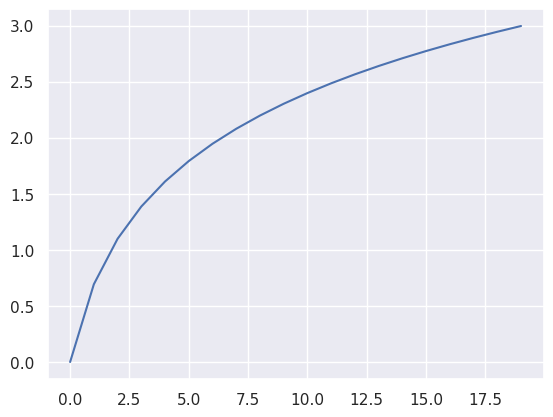

In [31]:
plt.plot(np.log1p(range(20)))

In [8]:
edge_features = [get_edge_features(i) for i in range(5)]

In [9]:
edge_df = pd.concat(edge_features)
edge_df.shape

(334471, 17)

In [10]:
#edge_df.to_csv('/disk/home/vmpouli/TNT/edge_data/edge_df_0.csv')

In [11]:
# i=0
# edge_df = get_edge_features(i)
# sns.histplot(edge_df[['source', 'internal']].groupby('source').sum())

In [12]:
edge_df.head(3)

,source,target,internal,umap_weight,nb_triangles,sigma_sum,rho_sum,highdim_dist,highdim_rank,status,dataset_name,umap_weight_norm,nb_triangles_norm,sigma_sum_norm,rho_sum_norm,highdim_dist_norm,highdim_rank_norm
edge ID,,,,,,,,,,,,,,,,,
0,0,30,True,0.166892,3.0,5.323761,26.606928,20.784609,8.0,Internal,pendigits,-0.165386,-1.25,-0.192883,-0.664399,-0.244629,-0.1
1,0,276,True,0.073232,12.0,3.945984,24.145357,17.378147,15.0,Internal,pendigits,-0.466861,1.00,-0.640457,-0.988443,-0.788817,0.6
2,0,286,True,0.026902,4.0,3.936890,28.188140,22.583179,13.0,Internal,pendigits,-0.615988,-1.00,-0.643412,-0.456247,0.042696,0.4


In [13]:
# X = edge_df[['log_triangles', 'log_sigma', 'log_rho', 'log_rank', 'umap_weight']].to_numpy()
feature_names = ['nb_triangles_norm', 'sigma_sum_norm', 'rho_sum_norm', 'highdim_dist_norm', 'highdim_rank_norm', 'umap_weight_norm']
X = edge_df[feature_names].to_numpy()
dataset = edge_df.dataset_name.tolist()
y = edge_df.internal.to_numpy()
X.shape

(334471, 6)

In [20]:
X_mapper = umap.UMAP().fit(X)

In [21]:
import umap.plot

In [22]:
X_2d = X_mapper.embedding_

## Plotting all edges: labels is a combination of edge class and dataset id.

In [23]:
new_label = np.array([str(x) for x in zip(y, dataset)])

<AxesSubplot:>

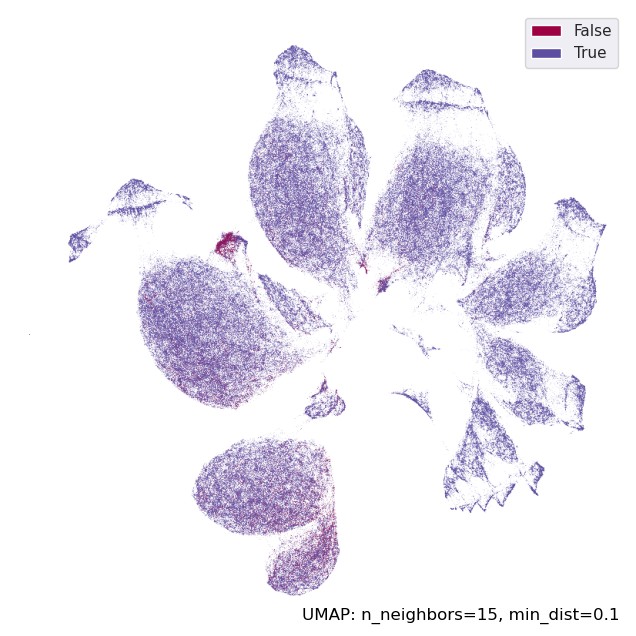

In [29]:
umap.plot.points(X_mapper, labels=y)

<AxesSubplot:>

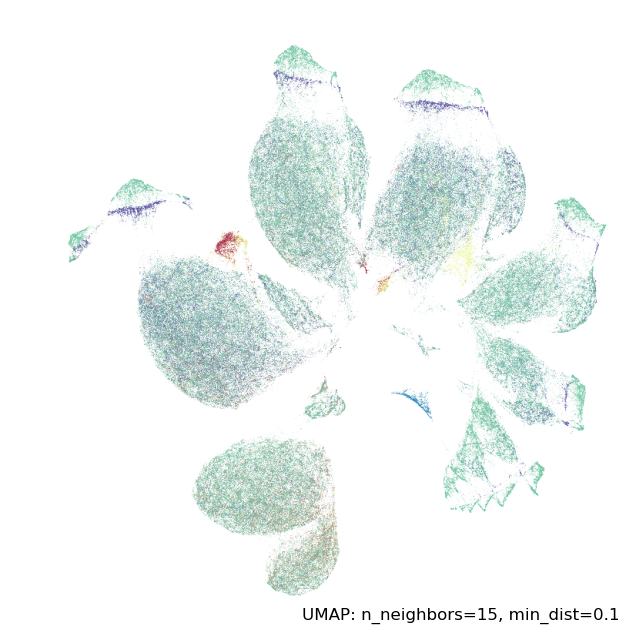

In [24]:
umap.plot.points(X_mapper, labels=new_label, show_legend=False)

<AxesSubplot:>

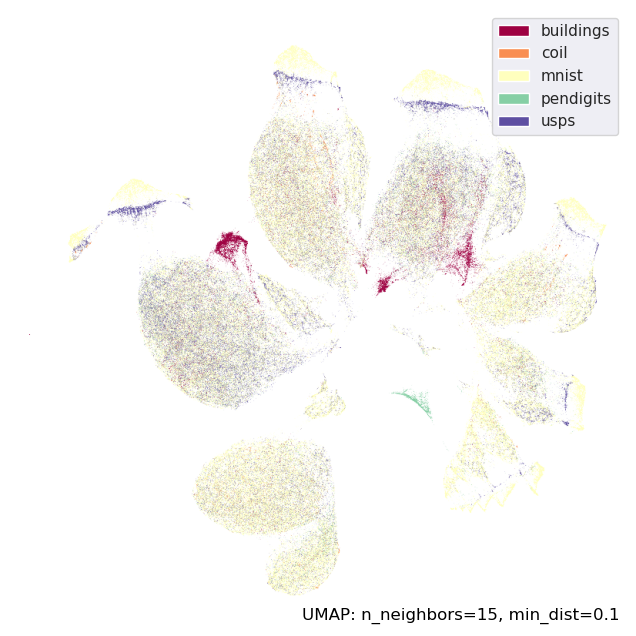

In [26]:
umap.plot.points(X_mapper, labels=edge_df.dataset_name)

In [27]:
import hdbscan

In [ ]:
hdbscan.RobustSingleLinkage()

## Decision Tree on imbalanced problem

Compare using standard accuracy with balanced_accuracy measures

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from numpy import mean
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

In [ ]:
Counter(y)

In [ ]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}
scoring = ["accuracy", "balanced_accuracy"]

### Majority Vote

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X, y, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

### Decision Tree on imbalanced data

In [ ]:
dt_clf = make_pipeline(
    DecisionTreeClassifier(random_state=1234),
)

index += ["Decision Tree"]
cv_result = cross_validate(dt_clf, X, y, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

### Decision Tree on under-sampling of majority class

In [ ]:
dt_clf = make_pipeline(
    RandomUnderSampler(random_state=42),
    DecisionTreeClassifier(class_weight={True:1, False:10}, random_state=1234),
)

index += ["Under-sampling + Decision Tree"]
cv_result = cross_validate(dt_clf, X, y, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from imblearn.ensemble import BalancedBaggingClassifier

bag_clf = make_pipeline(
    BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2,
    ),
)

index += ["Balanced bag of histogram gradient boosting"]
cv_result = cross_validate(bag_clf, X, y, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:
data_set_list

In [ ]:
w0 = np.array([x==data_set_list[2] for x in dataset])
X0 = X[w0]
y0 = y[w0]

w1 = np.array([x==data_set_list[3] for x in dataset])
X1 = X[w1]
y1 = y[w1]

In [ ]:
X0.shape

In [ ]:
model = BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2,
    )

In [ ]:
yhat1 = model.fit(X0, y0).predict_proba(X1)

In [ ]:
yhat1

# Class Imbalance Problem

From: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

## Grid search for imbalanced datasets

In [55]:
# define grid
balance = [{0:5,1:100}, {0:10,1:100}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.661933 using {'class_weight': {0: 5, 1: 100}}
0.661933 (0.021797) with: {'class_weight': {0: 5, 1: 100}}
0.661896 (0.020569) with: {'class_weight': {0: 10, 1: 100}}
0.653293 (0.024991) with: {'class_weight': {0: 1, 1: 1}}
0.661319 (0.022703) with: {'class_weight': {0: 1, 1: 10}}
0.660981 (0.019130) with: {'class_weight': {0: 1, 1: 100}}


## SMOTE

In [64]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot
from numpy import where

Counter({True: 16136, False: 983})
Counter({True: 16136, False: 16136})


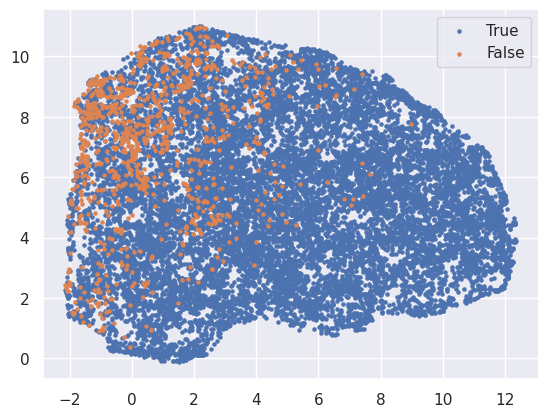

In [62]:
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X_2d, y)
# summarize the new class distribution
counter = Counter(y_resample)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X_resample[row_ix, 0], X_resample[row_ix, 1], label=str(label), s=5)
pyplot.legend()
pyplot.show()

In [80]:
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.757


### In SMOTE, there is a value fixed for the number of nearest neighbors to use. We could Grid Search over a range of values

In [77]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.745
> k=2, Mean ROC AUC: 0.754
> k=3, Mean ROC AUC: 0.755
> k=4, Mean ROC AUC: 0.752
> k=5, Mean ROC AUC: 0.752
> k=6, Mean ROC AUC: 0.758
> k=7, Mean ROC AUC: 0.752


## Borderline-SMOTE

Counter({True: 16136, False: 983})
Counter({True: 16136, False: 16136})


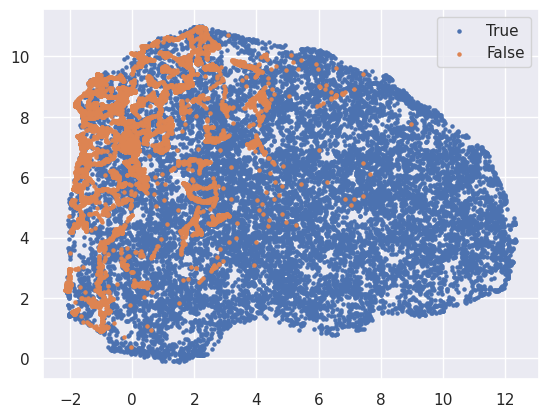

In [83]:
# borderline-SMOTE with SVM for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SVMSMOTE()
X_over, y_over = oversample.fit_resample(X_2d, y)
# summarize the new class distribution
counter = Counter(y_over)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_over == label)[0]
    pyplot.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label), s=5)
pyplot.legend()
pyplot.show()

In [87]:
# define pipeline
model = DecisionTreeClassifier(max_depth=3)
over = SVMSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.881


In [ ]:
X_train
pipe = pipeline.fit(X_train, y_train)